In [217]:
import sklearn

import gensim
import pickle

with open(r'data/features/w2v_package_1084.pkl', 'rb') as f:
    w2v = pickle.load(f)
    
with open(r'data/features/ner_package_1084.pkl', 'rb') as f:
    ner = pickle.load(f)

In [154]:
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from scipy.sparse import hstack
from sklearn.metrics import classification_report
from sklearn import preprocessing
from ScriptFeaturizer import scripts_to_tfidf
from FeatureUtils import tokenize_script
import warnings
import matplotlib.patches as mpatches

def run_classification_models(features, budget_cats):
    # making test train splits
    X_train, X_test, y_train, y_test = train_test_split(features, budget_cats, test_size=0.2, random_state=0)

    # The Naive Bayes are bad, so I remove
    classifiers = [
        (LogisticRegression(random_state=0, max_iter = 1000), {
            'C': np.logspace(-2, 7, 10)
        }),
        (GradientBoostingClassifier(n_estimators=50, random_state=0), {
            'learning_rate': np.logspace(-4, 0, 10)
        }),
        (SVC(random_state=0), {
            'C': np.logspace(-2, 7, 10)
        })]

    for classifier, parameters in classifiers:
        print(classifier)

        clf = GridSearchCV(classifier, parameters, cv = 3)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        y_true, y_pred = y_test, clf.predict(X_test)

        print("Accuracy Score: \n")
        print(accuracy_score(y_test, y_pred))

        print("F1 Score: \n")
        print(f1_score(y_true, y_pred, average = 'macro'))
        print(classification_report(y_true, y_pred))

        disp = plot_roc_curve(clf, X_test, y_test)
        plt.show()


In [63]:
from ScriptFeaturizer import scripts_to_tfidf, num_lines
from FeatureUtils import load_scripts
raw_scripts, titles = load_scripts(r'data/IMSDB/texts/')
titles = [title.replace(':', '_').replace('\\', '_').rstrip('_') for title in titles]
X_tfidf_sparse, vocab = scripts_to_tfidf(raw_scripts)

/Users/johnnyma/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cut', 'fade', 'll', 'scene', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [106]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tfidf = scaler.fit_transform(X_tfidf_sparse.toarray())
X_w2v = scaler.fit_transform(w2v[0])
X_ner = scaler.fit_transform(ner[0])
X_tfidf.shape, X_w2v.shape, X_ner.shape

((1084, 4525), (1084, 300), (1084, 18))

In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [108]:
import pandas as pd 

budgets = pd.read_csv(r'data/IMSDB/final_movie_budgets.csv')
budgets[['Movie-Title', 'Budget']].head(20)
print(titles[470:500])

['Hellboy', 'Hellboy_2__The_Golden_Army', 'Hellraiser', 'Hellraiser__Deader', 'Hellraiser_3__Hell_on_Earth', 'Help', "Henry's_Crime", 'Her', 'Hesher', 'High_Fidelity', 'Highlander', 'Highlander__Endgame', 'Hills_Have_Eyes', 'Hitchcock', "Hitchhiker's_Guide_to_the_Galaxy", 'Hollow_Man', 'Honeydripper', 'Horrible_Bosses', 'Horse_Whisperer', 'Hospital', 'Hostage', 'Hot_Tub_Time_Machine', 'Hotel_Rwanda', 'House_of_1000_Corpses', 'How_to_Lose_Friends_&_Alienate_People', 'How_to_Train_Your_Dragon', 'How_to_Train_Your_Dragon_2', 'Hudson_Hawk', 'Hudsucker_Proxy', 'Human_Nature']


In [109]:
X_ner_pd = pd.DataFrame(X_ner, index=titles)
X_w2v_pd = pd.DataFrame(X_w2v, index=titles)
X_tfidf_pd = pd.DataFrame(X_tfidf, index=titles)

In [110]:
budgets['Title_fixed'] = budgets['Movie-Title'].str.replace('[\:]', '_').str.rstrip('_')
budgets.set_index('Title_fixed', inplace=True)

In [111]:
print(budgets['Budget'])
print(X_ner_pd)

Title_fixed
10_Things_I_Hate_About_You     30,000,000
12                              5,000,000
12_and_Holding                    400,000
12_Monkeys                     29,000,000
12_Years_a_Slave               20,000,000
                                 ...     
You've_Got_Mail                65,000,000
Youth_in_Revolt                18,000,000
Zero_Dark_Thirty               40,000,000
Zerophilia                        325,000
Zootopia                      150,000,000
Name: Budget, Length: 1084, dtype: object
                                   0         1         2         3         4  \
10_Things_I_Hate_About_You -1.089018 -0.234329  0.766038 -0.565162  0.626483   
12                         -1.211914 -0.684930 -0.504064  0.088482 -0.288294   
127_Hours                  -0.530778  0.150559 -0.535042 -0.558690 -0.288294   
12_Monkeys                 -0.251659  0.540811 -0.471149 -0.183330 -0.059600   
12_Years_a_Slave            1.606362  0.499238  2.237496 -0.358067 -0.288294   
... 

In [176]:
X_ner_pd['Budget'] = budgets['Budget']
X_w2v_pd['Budget'] = budgets['Budget']
X_tfidf_pd['Budget'] = budgets['Budget']

X_ner_pd['Budget'] = pd.qcut(X_ner_pd['Budget'].str.replace(',', '').astype('float'), 2, labels=['low', 'high'])
X_w2v_pd['Budget'] = pd.qcut(X_w2v_pd['Budget'].str.replace(',', '').astype('float'), 2, labels=['low', 'high'])
X_tfidf_pd['Budget'] = pd.qcut(X_tfidf_pd['Budget'].str.replace(',', '').astype('float'), 2, labels=['low', 'high'])

In [122]:
X_w2v_pd.iloc[:, :-1].head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
10_Things_I_Hate_About_You,0.842147,0.128274,-0.612184,0.216559,-0.948937,1.363040,0.181481,1.610154,-0.295793,0.978330,...,-0.557664,0.160895,0.378660,-1.492968,0.885228,0.875905,-0.184535,-0.483838,0.496968,-0.141394
12,-0.014232,0.322377,-0.817613,0.170794,2.327757,0.963366,2.742541,-0.536997,1.545606,-0.161760,...,0.779170,0.394381,-1.022944,-0.445496,-0.554899,-0.722570,-0.825712,-0.573542,0.491641,2.121595
127_Hours,-1.386380,-0.594669,0.700672,1.134125,0.945979,1.065385,-0.497892,-1.245517,1.090233,-2.615434,...,2.561621,-0.592288,-0.187767,0.450739,0.775929,-0.329151,0.345485,-0.550136,-1.451380,0.391357
12_Monkeys,-0.205257,0.628661,-0.155096,-1.270163,-0.043059,-0.835741,-0.563652,-0.578076,-0.203944,-0.367297,...,-0.844965,-0.358733,-1.131822,-0.022966,-0.318367,-0.140076,-0.112031,-0.214689,-0.552245,0.393307
12_Years_a_Slave,-0.208633,0.489289,-1.128266,-0.158492,0.413465,-1.602130,0.259545,-1.048405,-1.258195,-0.649959,...,-0.465660,1.555572,1.104952,0.413394,-0.770204,0.260212,-0.488328,-0.149481,0.891459,-1.581208


LogisticRegression(max_iter=1000, random_state=0)
Best parameters set found on development set:

{'C': 0.01}

Grid scores on development set:

0.723 (+/-0.023) for {'C': 0.01}
0.720 (+/-0.015) for {'C': 0.1}
0.713 (+/-0.023) for {'C': 1.0}
0.710 (+/-0.035) for {'C': 10.0}
0.707 (+/-0.033) for {'C': 100.0}
0.707 (+/-0.031) for {'C': 1000.0}
0.714 (+/-0.023) for {'C': 10000.0}
0.717 (+/-0.017) for {'C': 100000.0}
0.717 (+/-0.017) for {'C': 1000000.0}
0.719 (+/-0.014) for {'C': 10000000.0}

Detailed classification report:
Accuracy Score: 

0.7096774193548387
F1 Score: 

0.7080904490423419
              precision    recall  f1-score   support

        high       0.73      0.65      0.69       106
         low       0.70      0.77      0.73       111

    accuracy                           0.71       217
   macro avg       0.71      0.71      0.71       217
weighted avg       0.71      0.71      0.71       217



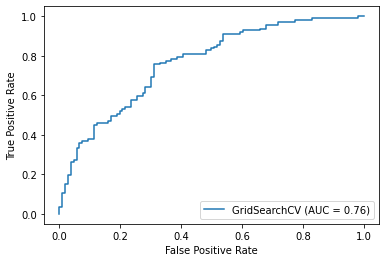

GradientBoostingClassifier(n_estimators=50, random_state=0)



KeyboardInterrupt



In [155]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

run_classification_models(X_tfidf_pd.iloc[:, :-1], X_tfidf_pd['Budget'])
run_classification_models(X_ner_pd.iloc[:, :-1], X_ner_pd['Budget'])
run_classification_models(X_w2v_pd.iloc[:, :-1], X_w2v_pd['Budget'])

In [152]:
# create ensemble of features
bow_ner = X_tfidf_pd.iloc[:, :-1].join(X_ner_pd, rsuffix = '_NER')
bow_w2v = X_tfidf_pd.iloc[:, :-1].join(X_w2v_pd, rsuffix = '_W2V')
w2v_ner = X_w2v_pd.iloc[:, :-1].join(X_ner_pd, rsuffix = '_NER')
bow_ner_w2v = bow_w2v.iloc[:, :-1].join(X_ner_pd, rsuffix = '_NER')
print(bow_ner.shape, bow_w2v.shape, w2v_ner.shape, bow_ner_w2v.shape)

(1084, 4544) (1084, 4826) (1084, 319) (1084, 4844)


In [ ]:
run_classification_models(bow_ner.iloc[:, :-1], bow_ner['Budget'])
run_classification_models(bow_w2v.iloc[:, :-1], bow_w2v['Budget'])
run_classification_models(w2v_ner.iloc[:, :-1], w2v_ner['Budget'])
run_classification_models(bow_ner_w2v.iloc[:, :-1], bow_ner_w2v['Budget'])

Detailed classification report:
Accuracy Score: 

0.7004608294930875
F1 Score: 

0.6983855447450016
              precision    recall  f1-score   support

        high       0.72      0.63      0.67       106
         low       0.69      0.77      0.72       111

    accuracy                           0.70       217
   macro avg       0.70      0.70      0.70       217
weighted avg       0.70      0.70      0.70       217



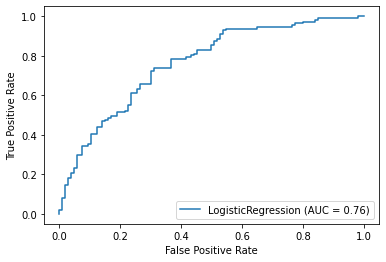

In [231]:
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(bow_ner.iloc[:, :-1], bow_ner['Budget'], test_size=0.2, random_state=0)

clf = LogisticRegression(random_state=0, max_iter = 1000, C = 0.1)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

print("Detailed classification report:")
y_true, y_pred = y_test, clf.predict(X_test)

print("Accuracy Score: \n")
print(accuracy_score(y_test, y_pred))

print("F1 Score: \n")
print(f1_score(y_true, y_pred, average = 'macro'))
print(classification_report(y_true, y_pred))

fig, ax = plt.subplots()
plot_roc_curve(clf, X_test, y_test, ax = ax)
plt.savefig('AUC.png')
plt.show()

In [222]:
clf.coef_.shape

(1, 4543)